# Project 4 Sparsification 
This is a jupter notebook to implement project 4 in math 296. The project uses 2 layers neural networks to do classification of mnist. We add the implementation of Relaxed Variables Splitting Methods here to see how the sparsification will changes the accuracy.   

In [1]:
from datetime import datetime 

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from __future__ import division, print_function, absolute_import
import tensorflow as tf 

# Import MNIST data 
from tensorflow.examples.tutorials.mnist import input_data 
mnist = input_data.read_data_sets("/tmp/data", one_hot = True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
tf.reset_default_graph()

In [5]:

# Training Parameters 
learning_rate = 0.001
beta = 0.1
lamda = 0.005
gamma = lamda/beta
num_steps = 550
batch_size = 128
display_step = 10
thres = tf.math.sqrt(2*gamma)

# Network Parameters 
num_input = 784 #MNIST data input 
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units 

# tf Graph input 
X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

In [35]:
# Create some wrappers for simplicity 
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation 
    x = tf.nn.conv2d(x, W, strides = [1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x,b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # MaxPool2D wrapper 
    return tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,k,k,1],
                         padding = 'SAME')

# Create model
def conv_net(x, weights, biases, dropout):
    # MNIST data input is a 1-D vector of 784 features 
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1, 28, 28, 1])
    
    # Convolution Layer 
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    
    # Convolution Layer 
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    
    # Fully Connected Layer 
    # Reshape conv2 output to fit fully connected layer input 
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout 
    fc1 = tf.nn.dropout(fc1, dropout)
    fc1 = tf.math.l2_normalize(fc1)
    
    # Output, class predictin 
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    
    return out 

In [7]:
def tf_hard_threshold(x):
    condition = tf.less(tf.abs(x), thres)
    u = tf.where(condition, tf.zeros_like(x), x)
    return u

##  2 Layer Neural Networks without Relaxed Variable Splitting 

In [8]:
# Store layers weight & bias 
weights = {
    # 5x5 conv, 1 input, 32 outputs 
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32]), name = "wc1"),
    # 5 x5 conv, 32 inputs, 64 outputs 
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64]), name = "wc2"),
    # fully connected, 7*7*64 inputs, 1024 outputs 
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024]), name = "wd1"),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]), name = "wout")
}
biases = {
    'bc1': tf.Variable(tf.random_normal([32]), name = "bc1"),
    'bc2': tf.Variable(tf.random_normal([64]), name = "bc2"),
    'bd1': tf.Variable(tf.random_normal([1024]), name = "bd1"),
    'out': tf.Variable(tf.random_normal([num_classes]), name = "bout")
}

bd = tf.print(biases['bd1'])

# Construct model 
logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer 
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits = logits, labels= Y))

tvars = tf.trainable_variables()
grad = tf.gradients(loss_op, tvars)

optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate)

train_op = optimizer.apply_gradients(zip(grad, tvars))

# Evaluate mdel 
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [9]:
# Start training 
with tf.Session() as sess:
    
    
    # Run the initializer 
    sess.run(init)
    
    for step in range(1, num_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
        if step% display_step == 0 or step == 1:
            # Calculate batch loss and accuracy 
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X:batch_x,
                                                                 Y:batch_y,
                                                                keep_prob: 1.0})
            print("Step "+ str(step) + ", Minibatch Loss= " + \
                 "{:.4f}".format(loss) + ", Training Accuracy=" + \
                 "{:.3f}".format(acc))
    variable_dict = {}
    for var in tf.trainable_variables():
        variable_dict[var.name] = var.eval()

    print("Optimization Finished!")
    
    # Calculate accuracy for 265 MNIST test images 
    print("Testing Accuracy: ", \
         sess.run(accuracy, feed_dict={X: mnist.test.images[:256],
                                       Y: mnist.test.labels[:256],
                                       keep_prob: 1.0}))

Step 1, Minibatch Loss= 64660.1641, Training Accuracy=0.094
Step 10, Minibatch Loss= 23745.6250, Training Accuracy=0.211
Step 20, Minibatch Loss= 8267.0449, Training Accuracy=0.594
Step 30, Minibatch Loss= 5117.6045, Training Accuracy=0.695
Step 40, Minibatch Loss= 3195.0684, Training Accuracy=0.742
Step 50, Minibatch Loss= 3019.5234, Training Accuracy=0.820
Step 60, Minibatch Loss= 3013.1924, Training Accuracy=0.828
Step 70, Minibatch Loss= 2425.7803, Training Accuracy=0.859
Step 80, Minibatch Loss= 1423.0693, Training Accuracy=0.875
Step 90, Minibatch Loss= 1453.7117, Training Accuracy=0.891
Step 100, Minibatch Loss= 1969.5510, Training Accuracy=0.891
Step 110, Minibatch Loss= 686.2379, Training Accuracy=0.906
Step 120, Minibatch Loss= 2058.1938, Training Accuracy=0.891
Step 130, Minibatch Loss= 1751.8101, Training Accuracy=0.867
Step 140, Minibatch Loss= 956.0911, Training Accuracy=0.898
Step 150, Minibatch Loss= 1173.3921, Training Accuracy=0.930
Step 160, Minibatch Loss= 1269.5850

In [10]:
for key,val in variable_dict.items():
    print (key)

wc1:0
wc2:0
wd1:0
wout:0
bc1:0
bc2:0
bd1:0
bout:0


In [11]:
c_params_1 = variable_dict['wc1:0'].reshape(5*5*1*32,-1)
c_params_1.shape

(800, 1)

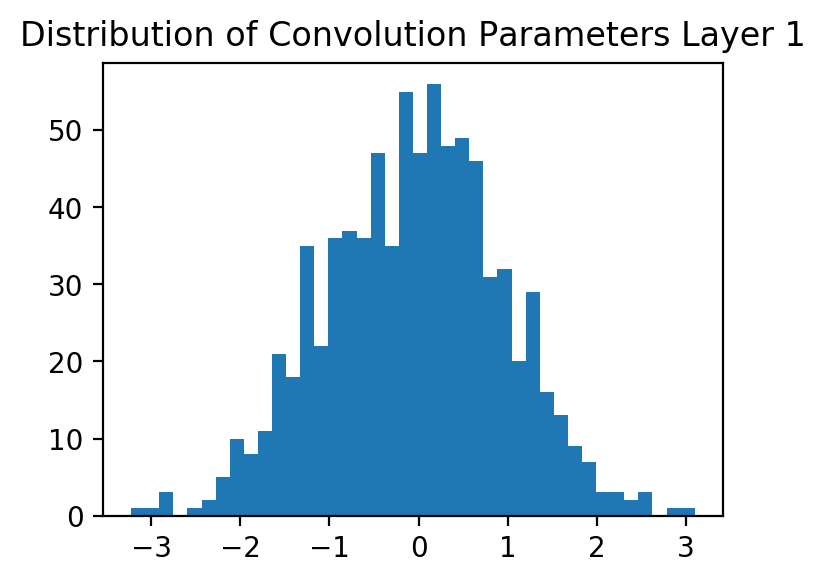

In [12]:
fig = plt.figure(figsize=(4,3), dpi = 200)
plt.hist(c_params_1,bins =40)
plt.title('Distribution of Convolution Parameters Layer 1')
plt.savefig("./images/Conv_dist_layer_1")
plt.show()

In [13]:
c_params_2 = variable_dict['wc2:0'].reshape(5*5*32*64,-1)
c_params_2.shape

(51200, 1)

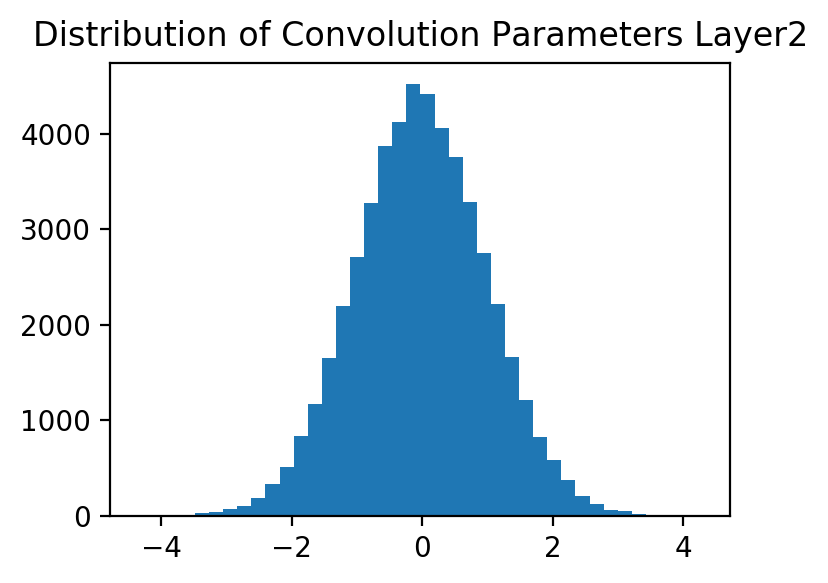

In [14]:
fig = plt.figure(figsize=(4,3), dpi = 200)
plt.hist(c_params_2,bins =40)
plt.title('Distribution of Convolution Parameters Layer2')
plt.savefig("./images/Conv_dist_layer_2")
plt.show()


In [15]:
fc_params = variable_dict['wd1:0'].reshape(3136*1024,-1)
fc_params.shape

(3211264, 1)

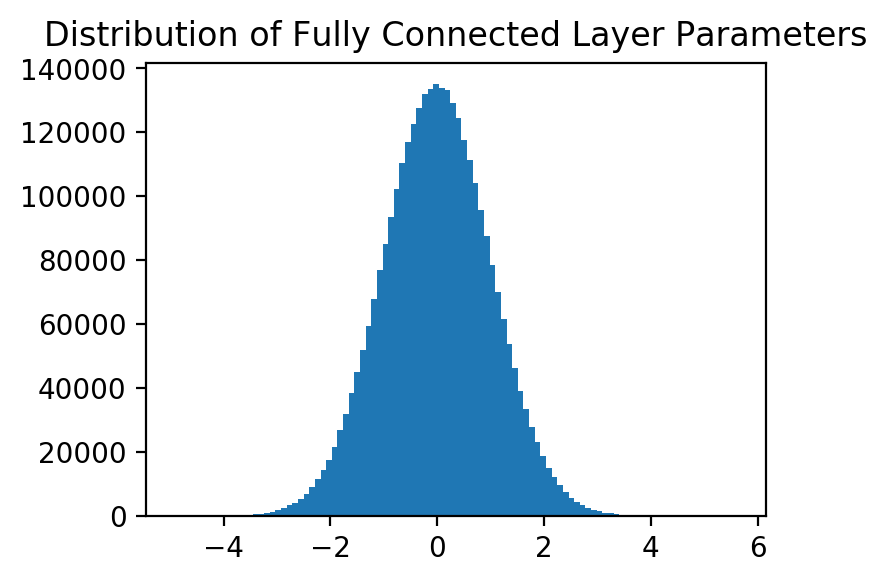

In [16]:
fig = plt.figure(figsize=(4,3), dpi = 200)
plt.hist(fc_params,bins =100)
plt.title('Distribution of Fully Connected Layer Parameters')
plt.savefig("./images/fc_layer")
plt.show()

## Total Size Changes in Conv Layer

In [17]:
c_params_1 = variable_dict['wc1:0']
c_params_1.shape

(5, 5, 1, 32)

In [18]:
c_params_1[:,:,0,1].shape
count = np.zeros([1,32])

In [19]:
for i in range(32):
    conv_mat = c_params_1[:,:,0,i]
    count_temp = 0
    for j in range(5):
        for k in range(4):
            if conv_mat[j][k]*conv_mat[j][k+1] <= -10e-6:
                count_temp += 1
    count[0][i] = count_temp
    

In [20]:
print(count)
np.savetxt("count.csv", count, fmt = '%d')

[[11.  8.  8.  9.  9.  8.  6. 13. 11. 10. 11.  9. 13.  9.  8.  7. 13.  7.
  10. 12. 11.  8. 11.  5. 10. 12. 12. 12. 13.  9. 10. 12.]]


In [21]:
c_params_2 = variable_dict['wc2:0']
c_params_2.shape

(5, 5, 32, 64)

In [22]:
count_2 = np.zeros([32,64])

In [23]:
for i in range(32):
    for l in range(64):
        conv_mat = c_params_2[:,:,i,l]
        count_temp = 0
        for j in range(5):
            for k in range(4):
                if conv_mat[j][k]*conv_mat[j][k+1] < - 10e-6:
                    count_temp += 1
        count_2[i][l] = count_temp
    

In [24]:
print(count_2)
np.savetxt("count2.csv", count_2, fmt = '%d')

[[ 7. 11. 10. ... 12. 16. 10.]
 [ 9.  8. 13. ...  8. 10. 11.]
 [13. 11. 12. ... 13.  9. 13.]
 ...
 [10.  9. 12. ... 12.  6. 12.]
 [13. 13. 11. ... 11.  9. 14.]
 [ 9. 10.  7. ...  8. 10. 14.]]


## 2 Layer Neural Networks with Relaxed Variables Splitting

In [82]:
tf.reset_default_graph()

In [83]:
# Training Parameters 
learning_rate = 0.001
beta = 0.1
lamda = 0.5
gamma = lamda/beta
num_steps = 500
batch_size = 128
display_step = 10
thres = tf.math.sqrt(2*gamma)

# Network Parameters 
num_input = 784 #MNIST data input 
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units 

# tf Graph input 
X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

In [84]:
def tf_hard_threshold(x):
    condition = tf.less(tf.abs(x), thres)
    u = tf.where(condition, tf.zeros_like(x), x)
    return u

In [85]:
# Store layers weight & bias 
weights = {
    # 5x5 conv, 1 input, 32 outputs 
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32]), name = "wc1"),
    # 5 x5 conv, 32 inputs, 64 outputs 
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64]), name = "wc2"),
    # fully connected, 7*7*64 inputs, 1024 outputs 
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024]), name = "wd1"),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]), name = "wout")
}
biases = {
    'bc1': tf.Variable(tf.random_normal([32]), name = "bc1"),
    'bc2': tf.Variable(tf.random_normal([64]), name = "bc2"),
    'bd1': tf.Variable(tf.random_normal([1024]), name = "bd1"),
    'out': tf.Variable(tf.random_normal([num_classes]), name = "bout")
}

bd = tf.print(biases['bd1'])

# Construct model 
logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer 
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits = logits, labels= Y))

tvars = tf.trainable_variables()
grad = tf.gradients(loss_op, tvars)
tuars2 = tf_hard_threshold(tvars[2])

new_grad = grad[2] + beta*tf.subtract(tvars[2], tuars2)
grad[2] = new_grad 
optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate)

train_op = optimizer.apply_gradients(zip(grad, tvars))

# Evaluate mdel 
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()


In [86]:
saver = tf.train.Saver()

In [87]:
# Start training 
with tf.Session() as sess:
    
    
    # Run the initializer 
    sess.run(init)
    
    for step in range(1, num_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
        if step% display_step == 0 or step == 1:
            # Calculate batch loss and accuracy 
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X:batch_x,
                                                                 Y:batch_y,
                                                                keep_prob: 1.0})
            print("Step "+ str(step) + ", Minibatch Loss= " + \
                 "{:.4f}".format(loss) + ", Training Accuracy=" + \
                 "{:.3f}".format(acc))
    variable_dict = {}
    for var in tf.trainable_variables():
        variable_dict[var.name] = var.eval()
    save_path = saver.save(sess, "2CNN_sparse_model_final.ckpt")

    print("Optimization Finished!")
    
    # Calculate accuracy for 265 MNIST test images 
    print("Testing Accuracy: ", \
         sess.run(accuracy, feed_dict={X: mnist.test.images[:256],
                                       Y: mnist.test.labels[:256],
                                       keep_prob: 1.0}))

Step 1, Minibatch Loss= 3.4828, Training Accuracy=0.055
Step 10, Minibatch Loss= 3.2220, Training Accuracy=0.078
Step 20, Minibatch Loss= 3.0934, Training Accuracy=0.109
Step 30, Minibatch Loss= 3.0971, Training Accuracy=0.094
Step 40, Minibatch Loss= 3.1188, Training Accuracy=0.117
Step 50, Minibatch Loss= 2.9575, Training Accuracy=0.094
Step 60, Minibatch Loss= 2.8917, Training Accuracy=0.141
Step 70, Minibatch Loss= 2.8733, Training Accuracy=0.117
Step 80, Minibatch Loss= 2.8815, Training Accuracy=0.070
Step 90, Minibatch Loss= 2.7589, Training Accuracy=0.086
Step 100, Minibatch Loss= 2.8822, Training Accuracy=0.078
Step 110, Minibatch Loss= 2.7849, Training Accuracy=0.070
Step 120, Minibatch Loss= 2.9570, Training Accuracy=0.047
Step 130, Minibatch Loss= 2.6319, Training Accuracy=0.141
Step 140, Minibatch Loss= 2.7333, Training Accuracy=0.086
Step 150, Minibatch Loss= 2.6728, Training Accuracy=0.125
Step 160, Minibatch Loss= 2.6655, Training Accuracy=0.117
Step 170, Minibatch Loss=

In [88]:
for key,val in variable_dict.items():
    print (key)

wc1:0
wc2:0
wd1:0
wout:0
bc1:0
bc2:0
bd1:0
bout:0


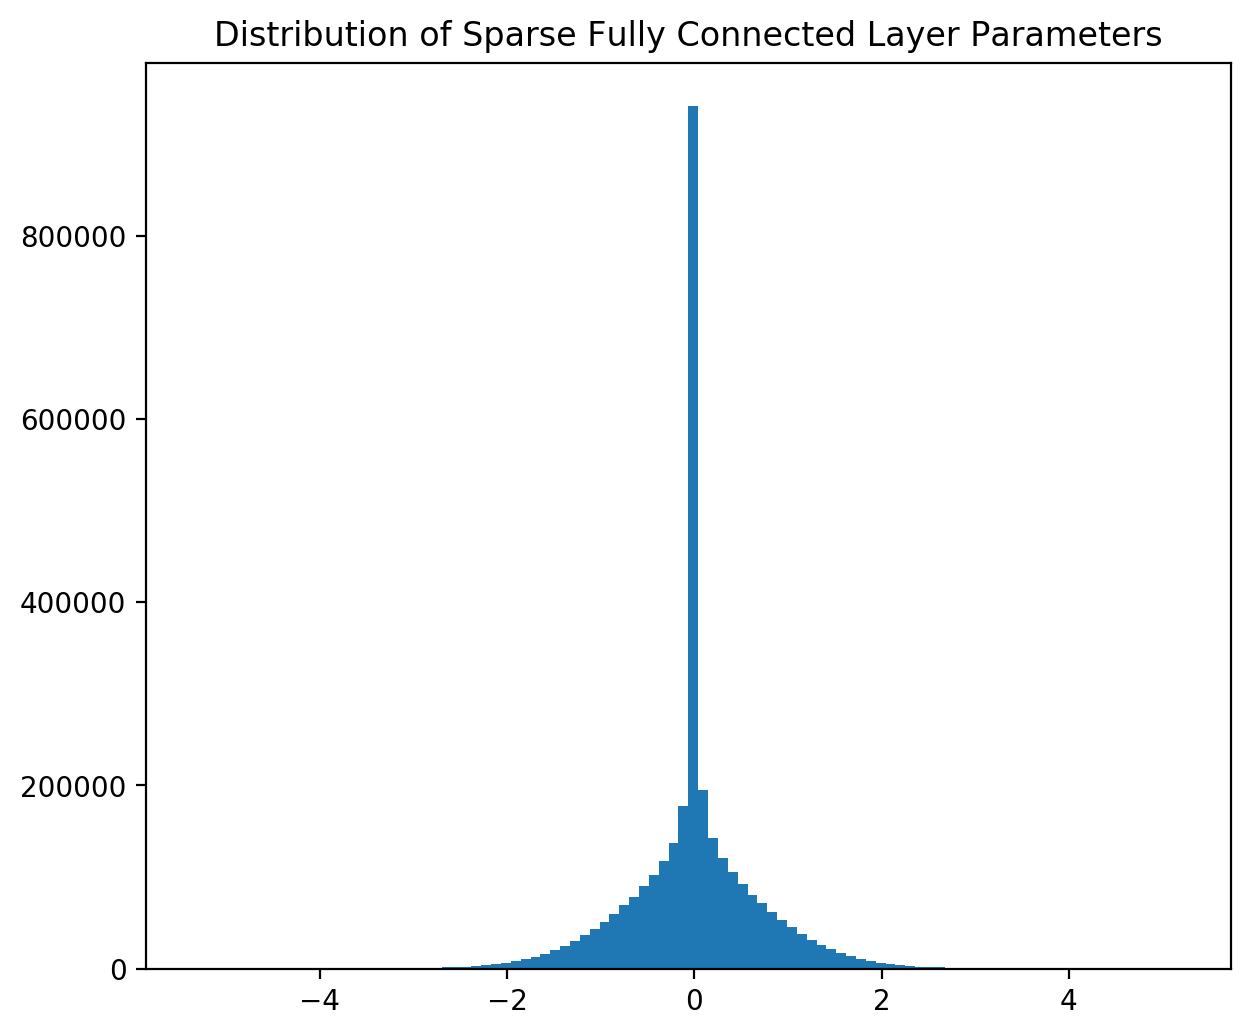

In [89]:
fc_params = variable_dict['wd1:0'].reshape(3136*1024,-1)
fig = plt.figure(figsize=(7,6), dpi = 200)
plt.hist(fc_params,bins =100)
plt.title('Distribution of Sparse Fully Connected Layer Parameters')
plt.savefig("./images/fc_layer_sparse_05")
plt.show()

In [90]:
np.count_nonzero(abs(fc_params)>10e-3)/len(fc_params)

0.7903800497249681